In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import trange
import torch.nn as nn

from cloudmanufacturing.data import read_fatahi_dataset
from cloudmanufacturing.graph import dglgraph, graph_gamma, os_type, so_type, ss_type
from cloudmanufacturing.graphconv import GNN
from cloudmanufacturing.solvers.mip_solver import mip_solve
from cloudmanufacturing.validation import construct_delta, objvalue,construct_delta2

In [2]:
dataset = read_fatahi_dataset("../data/fatahi.xlsx")
len(dataset)

  0%|          | 0/18 [00:00<?, ?it/s]

18

In [3]:
train_problem = dataset[0]
test_problem = dataset[2]
train_problem["name"], test_problem["name"]

('5,10,10-1', '5,10,10-3')

In [4]:
# train_delta, train_gamma, status, value = mip_solve(train_problem)
# print(f'Problem {train_problem["name"]}: {value:.2f}, {status}')

# np.save('gamma_0.npy', train_gamma)
# np.save('delta_0.npy', train_delta)

train_gamma = np.load('gamma_0.npy')
train_delta = np.load('delta_0.npy')

In [5]:
# test_delta, test_gamma, status, value = mip_solve(test_problem)
# print(f'Problem {test_problem["name"]}: {value:.2f}, {status}')

# np.save('gamma_1.npy', test_gamma)
# np.save('delta_1.npy', test_delta)

test_gamma = np.load('gamma_1.npy')
test_delta = np.load('delta_1.npy')

In [6]:
train_graph = dglgraph(train_problem, train_gamma, train_delta)
train_target = train_graph.edata["target"][os_type]
delta_train_target = train_graph.edata["delta_target"][os_type]
train_graph.edata["feat"][os_type][:, 0] /= 10
train_graph.edata["feat"][ss_type] /= 100

test_graph = dglgraph(test_problem, test_gamma, test_delta)
test_target = test_graph.edata["target"][os_type]
delta_test_target = test_graph.edata["delta_target"][os_type]
test_graph.edata["feat"][os_type][:, 0] /= 10
test_graph.edata["feat"][ss_type] /= 100

In [7]:
model = GNN(train_graph, 15, 1)
loss2 = nn.CrossEntropyLoss(weight=torch.tensor([1 for i in range(10)] + [0.05]))

train_loss = []
test_loss = []
train_objvalue = []
test_objvalue = []

optim = Adam(model.parameters(), lr=0.0005)
for i in trange(500):
    logits, delta_logits = model(train_graph)
    loss = F.binary_cross_entropy_with_logits(logits, train_target)
    serv = loss2(delta_logits, np.nonzero(delta_train_target)[:,1])
    loss = loss + serv*0.5
    optim.zero_grad()
    loss.backward()
    optim.step()
    print(torch.argmax(F.softmax(delta_logits), axis=1))
    print(np.where(torch.argmax(F.softmax(delta_logits), axis=1) != 10))

    if i % 10 == 0:
        with torch.no_grad():
            train_loss.append(loss.item())
            pred_gamma = model.predict(train_graph, train_problem)
            train_objvalue.append(
                objvalue(train_problem, pred_gamma, construct_delta2(train_problem,
                                                                     train_gamma,
                                                                     train_graph,
                                                                     delta_logits))
            )
            logits, delta_logits = model(test_graph)
            loss = F.binary_cross_entropy_with_logits(logits, test_target)
            serv = loss2(delta_logits, np.nonzero(delta_test_target)[:,1])
            loss = loss + serv
            test_loss.append(loss.item())
            pred_gamma = model.predict(test_graph, test_problem)
            test_objvalue.append(
                objvalue(test_problem, pred_gamma, construct_delta2(test_problem,
                                                                    test_gamma,
                                                                    test_graph,
                                                                    delta_logits))
            )


  0%|          | 0/500 [00:00<?, ?it/s]

/Users/fomindmitry/miniconda3/envs/graph/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
/var/folders/98/kw4wt9nx1rb06lqmrsj_l7680000gn/T/ipykernel_1014/131456348.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.argmax(F.softmax(delta_logits), axis=1))
/var/folders/98/kw4wt9nx1rb06lqmrsj_l7680000gn/T/ipykernel_1014/131456348.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(np.where(torch.argmax(F.softmax(delta_logits), axis=1) != 10))
/Users/fomindmitry/Documents

tensor([4, 4, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 4, 4, 5, 4, 4, 4, 4, 4, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 7, 7, 4, 5, 5, 4, 4, 5, 4, 4, 7, 7,
        7, 7, 7, 7, 7, 7, 4, 4, 5, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4,
        5, 5, 4, 4, 5, 4, 4, 4, 4, 4, 7, 4, 4, 4, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7,
        4, 4, 7, 7, 5, 5, 5, 5, 4, 5, 5, 4, 4, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 7,
        4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 7, 7, 4, 4, 5, 4, 4, 4, 5,
        4, 4, 5, 5, 4, 4, 5, 4, 4, 4, 4, 4, 7, 4, 4, 4, 5, 5, 7, 7, 7, 4, 4, 5,
        4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 7, 7])
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50

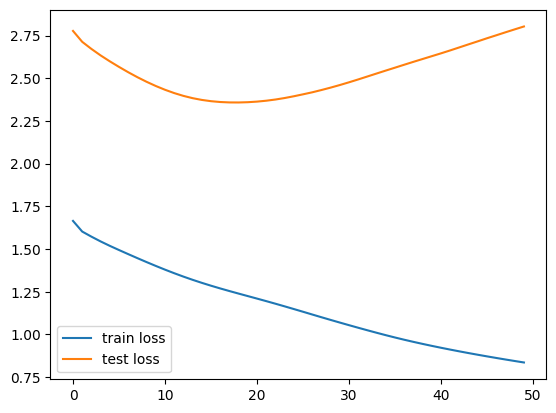

In [8]:
plt.plot(train_loss, label="train loss")
plt.plot(test_loss, label="test loss")
plt.legend()
plt.show()

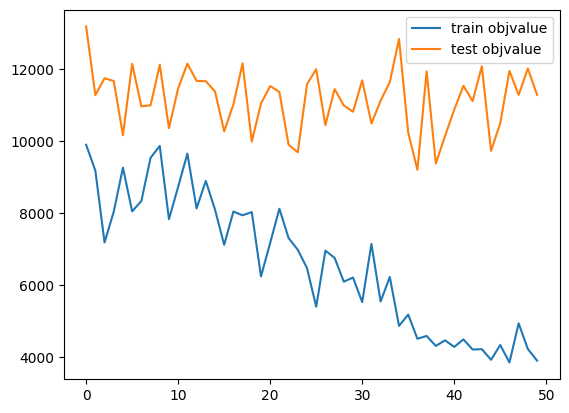

In [9]:
plt.plot(train_objvalue, label="train objvalue")
plt.plot(test_objvalue, label="test objvalue")
plt.legend()
plt.show()

In [10]:
min(test_objvalue)

9195.799565465411